# Лабораторная работа № 3
Шубина С. НПИбд-02-23


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

загрузка данных из файла в таблицу, проверка каждого столбца на наличие пропусков и вывод первых строк набора данных для предварительного ознакомления со структурой и содержимым.

In [2]:
# загружаем данные, проверяем на пропуски
data = pd.read_csv('covid_usa.csv', index_col=[0], parse_dates=[0])
data = data.asfreq('D')  # Устанавливаем частоту дневных данных

# проверка на пропуски 
print("Пропуски в данных:")
print(data.isnull().sum())

data.head()

Пропуски в данных:
cases    0
dtype: int64


,cases
date,
2020-05-01,33970
2020-05-02,29474
2020-05-03,26140
2020-05-04,21962
2020-05-05,23709


проводится визуальный анализ временного ряда.
Сначала выполняется декомпозиция данных по числу случаев заболевания на три компоненты — тренд, сезонность и остатки.
Затем создаются графики, на которых отдельно отображаются:

исходные данные,

трендовая составляющая (долгосрочная тенденция),

сезонная составляющая (периодические колебания),

остаточная часть (случайные колебания).

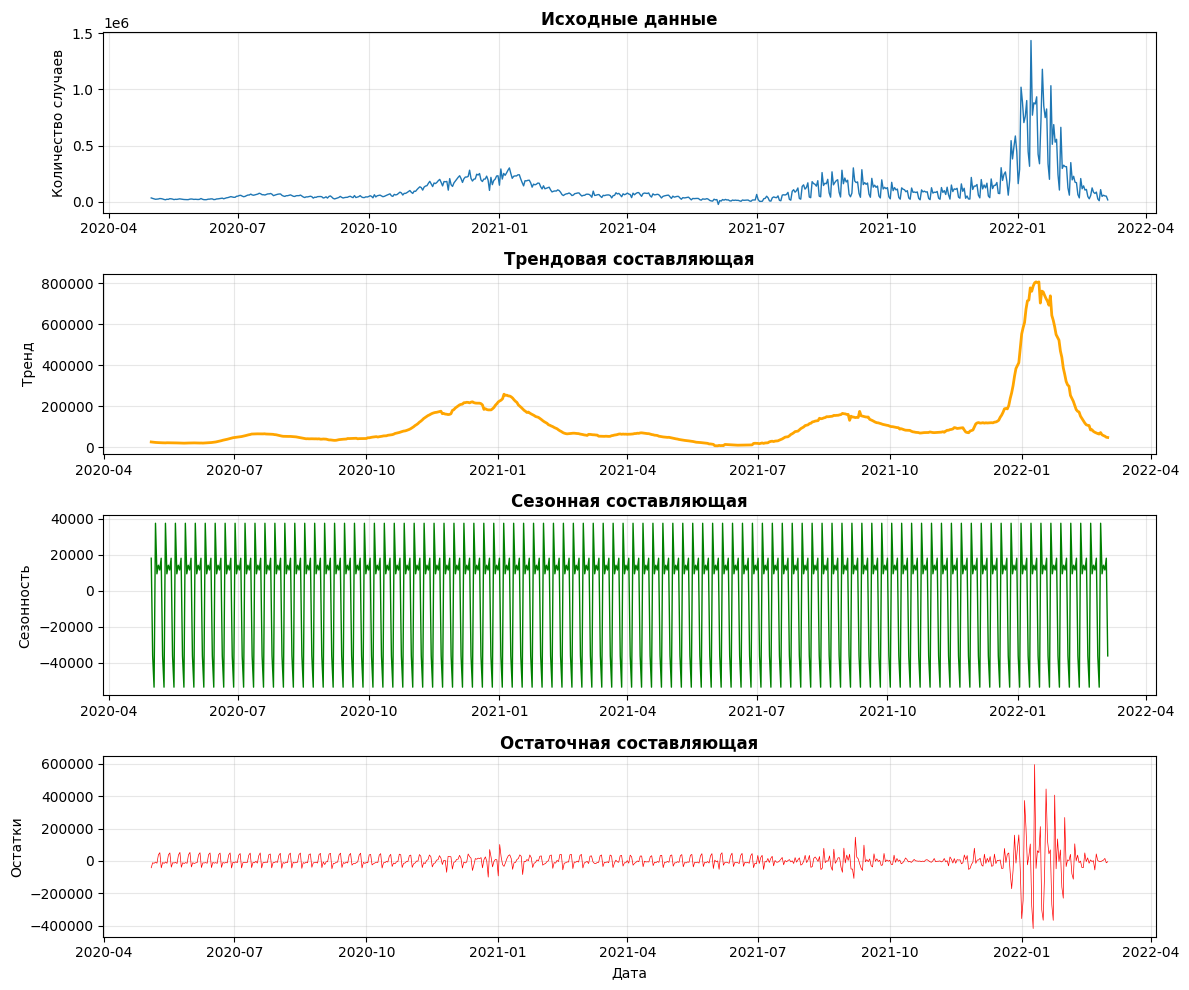

In [3]:
# 2. Визуальный анализ данных
from statsmodels.tsa.seasonal import seasonal_decompose

# Для seasonal_decompose нужно передать Series, а не DataFrame
decompose = seasonal_decompose(data, period=7)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Исходные данные
axes[0].plot(data.index, data['cases'], linewidth=1)
axes[0].set_title('Исходные данные', fontweight='bold')
axes[0].set_ylabel('Количество случаев')
axes[0].grid(True, alpha=0.3)

# Тренд
axes[1].plot(data.index, decompose.trend, linewidth=2, color='orange')
axes[1].set_title('Трендовая составляющая', fontweight='bold')
axes[1].set_ylabel('Тренд')
axes[1].grid(True, alpha=0.3)

# Сезонность
axes[2].plot(data.index, decompose.seasonal, linewidth=1, color='green')
axes[2].set_title('Сезонная составляющая', fontweight='bold')
axes[2].set_ylabel('Сезонность')
axes[2].grid(True, alpha=0.3)

# Остатки
axes[3].plot(data.index, decompose.resid, linewidth=0.5, color='red')
axes[3].set_title('Остаточная составляющая', fontweight='bold')
axes[3].set_ylabel('Остатки')
axes[3].set_xlabel('Дата')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

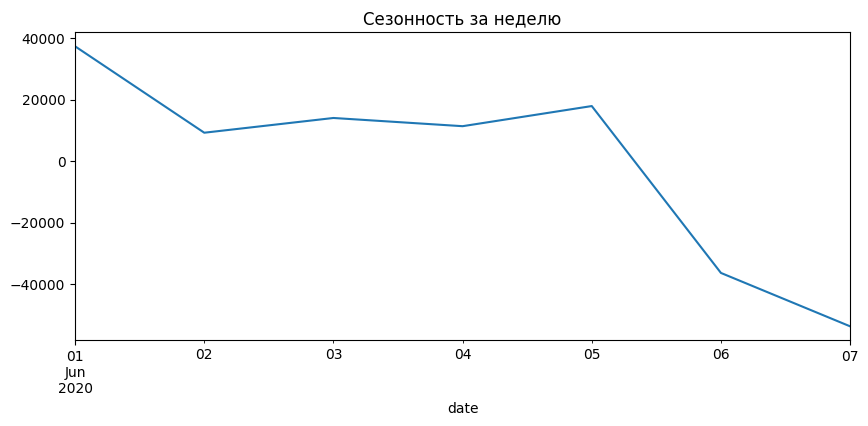

In [4]:
plt.figure(figsize=(10, 4))
decompose.seasonal['2020-06-01':'2020-06-07'].plot()
plt.title('Сезонность за неделю')
plt.show()

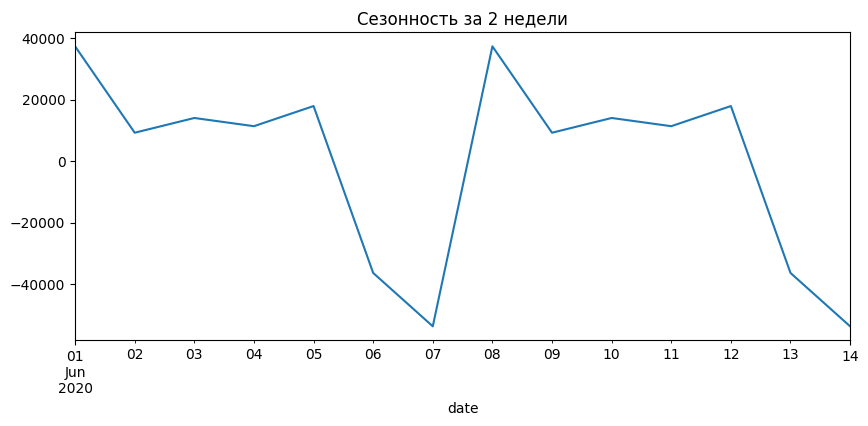

In [5]:
plt.figure(figsize=(10, 4))
decompose.seasonal['2020-06-01':'2020-06-14'].plot()
plt.title('Сезонность за 2 недели')
plt.show()

Создается копия исходных данных - чтобы не изменять оригинальные данные

Добавляются временные признаки:

День недели (от понедельника до воскресенья)

Месяц (от января до декабря)

Удаляются пропущенные значения - очистка данных для корректной работы моделей

Выводится информация о размере матрицы и списке признаков

In [6]:
# 3. Формирование матрицы признаков

# Простая матрица признаков
features = data.copy()

# Добавляем основные признаки
features['day_of_week'] = features.index.dayofweek  # день недели
features['month'] = features.index.month            # месяц

# Удаляем пропуски (если есть)
features = features.dropna()

print("Матрица признаков:")
print(f"Размер: {features.shape}")  # (количество_строк, количество_признаков)
print(f"Признаки: {features.columns.tolist()}")
features.head()

Матрица признаков:
Размер: (674, 3)
Признаки: ['cases', 'day_of_week', 'month']


,cases,day_of_week,month
date,,,
2020-05-01,33970,4,5
2020-05-02,29474,5,5
2020-05-03,26140,6,5
2020-05-04,21962,0,5
2020-05-05,23709,1,5


# Подготовка и обучение 


Разделение данных - исходный набор делится на обучающую (90%) и тестовую (10%) части без перемешивания, чтобы сохранить временной порядок

Разделение на признаки и целевую переменную:

Обучающая выборка: признаки и целевая переменная

Тестовая выборка: признаки и целевая переменная

Целевая переменная - столбец 'cases' (количество случаев)
Признаки - все остальные столбцы

In [14]:
# 4. Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('cases', axis=1)
target_train = train['cases']
features_test = test.drop('cases', axis=1)
target_test = test['cases']

print(f"Обучающая выборка: {len(features_train)} записей")
print(f"Тестовая выборка: {len(features_test)} записей")

Обучающая выборка: 606 записей
Тестовая выборка: 68 записей


Сначала создается копия исходных данных, чтобы не изменять их напрямую. Затем добавляются базовые временные характеристики: год, месяц, день и день недели, что позволяет модели учитывать временные закономерности. Далее генерируются лаговые признаки — значения целевой переменной за предыдущие 14 дней, что помогает модели использовать исторические данные для прогнозирования. Также рассчитывается скользящее среднее за 30 дней, которое сглаживает краткосрочные колебания и выделяет общий тренд. После создания всех признаков удаляются строки с пропущенными значениями, которые возникают из-за операций сдвига и скользящего окна. Завершающим этапом строится тепловая карта корреляций, которая визуализирует взаимосвязи между всеми признаками и помогает оценить их значимость для прогнозирования целевой переменной, выделяя наиболее информативные переменные для дальнейшего моделирования.

Размер данных после создания признаков: (644, 20)
Столбцы: ['cases', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'rolling_mean']

Матрица признаков: (644, 19)
Целевая переменная: (644,)


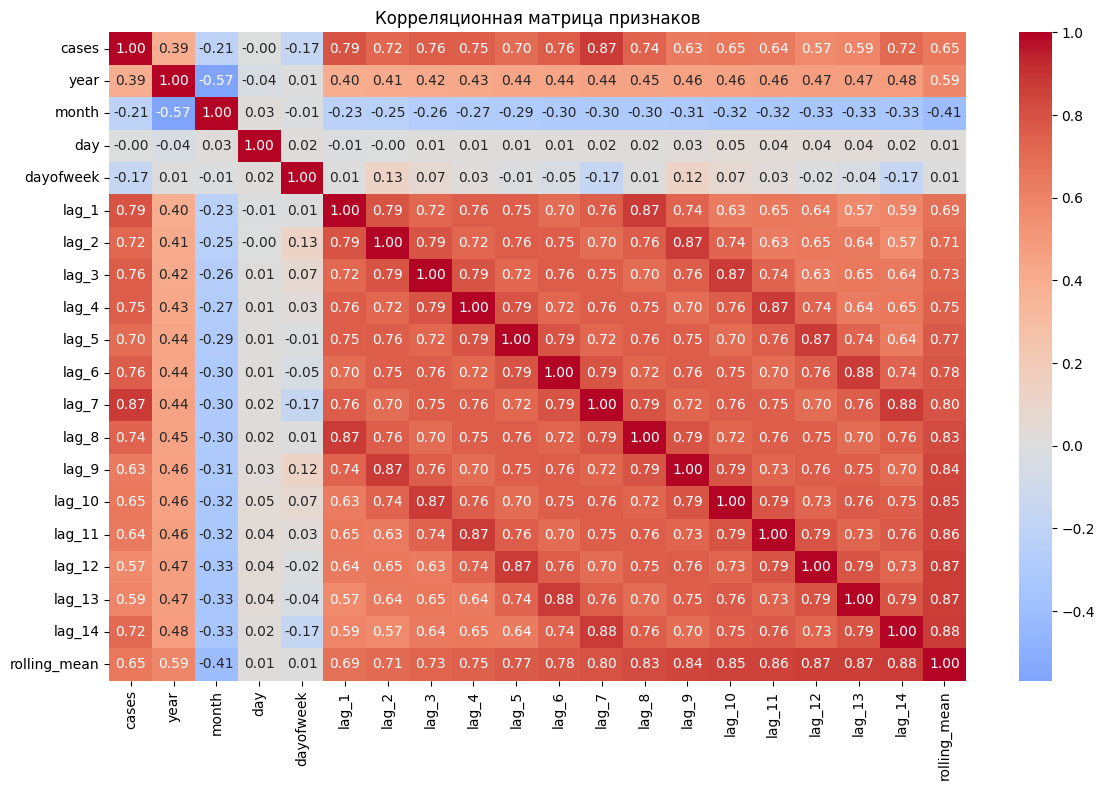

In [19]:
# Формируем матрицу признаков и целевую переменную
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['cases'].shift(lag)
    
    data['rolling_mean'] = data['cases'].shift().rolling(rolling_mean_size).mean()
    return data

max_lag = 14
rolling_mean_size = 30
df_with_features = make_features(data, max_lag, rolling_mean_size)
df_with_features = df_with_features.dropna()

print(f"Размер данных после создания признаков: {df_with_features.shape}")
print(f"Столбцы: {list(df_with_features.columns)}")

# Разделяем на признаки и целевую переменную
features = df_with_features.drop('cases', axis=1)  # Все столбцы кроме 'cases'
target = df_with_features['cases']  # Целевая переменная

print(f"\nМатрица признаков: {features.shape}")
print(f"Целевая переменная: {target.shape}")


# Построение тепловой карты корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

проводится подбор гиперпараметров для нескольких моделей машинного обучения с использованием кросс-валидации с учетом временных рядов. Сначала настраивается временное разделение данных на 5 блоков, где каждый последующий блок содержит более поздние данные относительно предыдущего. Затем определяются три модели регрессии: Lasso, Random Forest и Gradient Boosting, а также сетки гиперпараметров для каждой из них. Для каждой модели с помощью поиска по сетке находится оптимальная комбинация гиперпараметров, при этом оценивание производится через отрицательную среднюю квадратичную ошибку. Результаты сохраняются с переводом в метрику RMSE для удобства интерпретации, и в конце выводится таблица с лучшими параметрами и соответствующими оценками качества для каждой модели, что позволяет сравнить их эффективность и выбрать наиболее подходящую для дальнейшего использования.



In [22]:
# 5. Подбор гиперпараметров с кросс-валидацией
tscv = TimeSeriesSplit(n_splits=5, gap=7)

models = {
    'Lasso': Lasso(random_state=12345),
    'RandomForest': RandomForestRegressor(random_state=12345),
    'GradientBoosting': GradientBoostingRegressor(random_state=12345)
}

params = {
    'Lasso': {'alpha': [0.1, 1, 10]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
    'GradientBoosting': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.05]}
}

results = []
for name in models:
    print(f"Подбор параметров для {name}...")
    
    grid = GridSearchCV(
        models[name], 
        params[name], 
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(features_train, target_train)
    
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'best_score': np.sqrt(-grid.best_score_)
    })
    
    print(f"Лучшие параметры для {name}: {grid.best_params_}")
    print(f"Лучший RMSE: {np.sqrt(-grid.best_score_):.2f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
print("РЕЗУЛЬТАТЫ ПОДБОРА ПАРАМЕТРОВ:")
print(results_df)

# Находим лучшую модель
best_model_row = results_df.loc[results_df['best_score'].idxmin()]
print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model_row['model']}")
print(f" Лучшие параметры: {best_model_row['best_params']}")
print(f" Лучший RMSE: {best_model_row['best_score']:.2f}")

Подбор параметров для Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшие параметры для Lasso: {'alpha': 10}
Лучший RMSE: 28200.91
Подбор параметров для RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры для RandomForest: {'max_depth': 10, 'n_estimators': 100}
Лучший RMSE: 43735.44
Подбор параметров для GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры для GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Лучший RMSE: 42111.40
РЕЗУЛЬТАТЫ ПОДБОРА ПАРАМЕТРОВ:
              model                                        best_params  \
0             Lasso                                      {'alpha': 10}   
1      RandomForest             {'max_depth': 10, 'n_estimators': 100}   
2  GradientBoosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   

     best_score  
0  28200.914260  
1  43735.444944  
2  42111.397111  

 ЛУЧШАЯ МОДЕЛЬ: Lasso
 Лучш

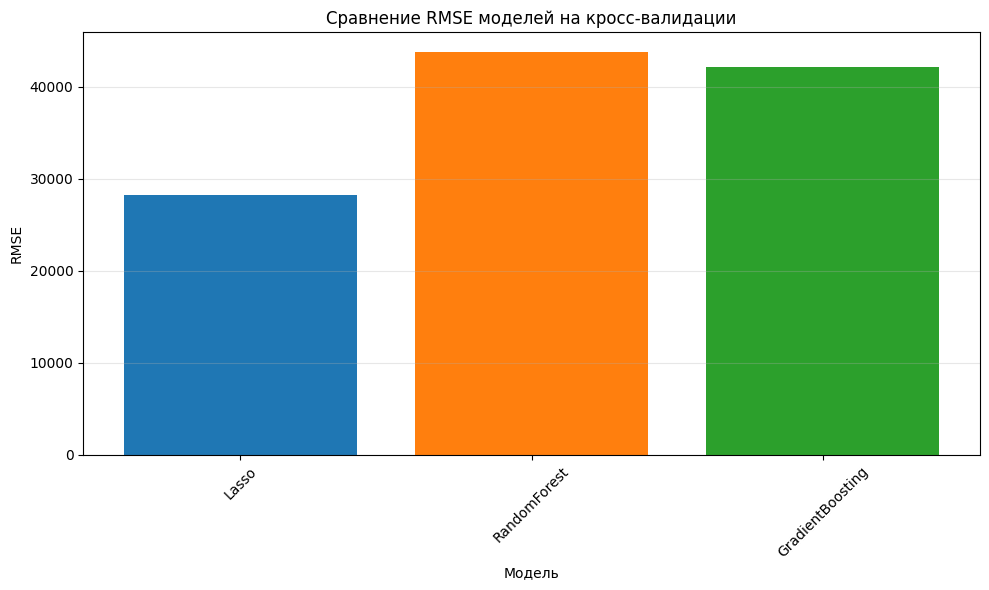

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['model'], results_df['best_score'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Сравнение RMSE моделей на кросс-валидации')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

выбирается и обучается лучшая модель машинного обучения на основе результатов предыдущего этапа подбора гиперпараметров. Сначала определяется модель с наименьшей ошибкой из таблицы результатов, затем извлекаются оптимальные параметры для этой модели. В зависимости от названия лучшей модели создается соответствующий экземпляр алгоритма с подобранными параметрами — Lasso, Random Forest или Gradient Boosting. Если по какой-то причине модель не распознана, создается простая заглушка. После этого модель обучается на тренировочных данных и выводятся все ее параметры, включая как подобранные гиперпараметры, так и стандартные настройки алгоритма, что обеспечивает полную прозрачность конфигурации финальной модели.



In [25]:
# 6. Обучение лучшей модели
best_model_name = results_df.loc[results_df['best_score'].idxmin(), 'model']
best_params = results_df.loc[results_df['best_score'].idxmin(), 'best_params']

if best_model_name == 'Lasso':
    best_model = Lasso(**best_params, random_state=12345)
elif best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(**best_params, random_state=12345)
elif best_model_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(**best_params, random_state=12345)
else:
    best_model = DummyRegressor(strategy='mean')

best_model.fit(features_train, target_train)

# Выводим все параметры модели
print(f"Лучшая модель: {best_model_name}")
print(f"Все параметры модели:")
for param, value in best_model.get_params().items():
    print(f"{param}: {value}")

Лучшая модель: Lasso
Все параметры модели:
alpha: 10
copy_X: True
fit_intercept: True
max_iter: 1000
positive: False
precompute: False
random_state: 12345
selection: cyclic
tol: 0.0001
warm_start: False


выполняется оценка качества лучшей модели на тестовой выборке. Сначала модель делает прогнозы для тестовых данных, используя обученную ранее модель. Затем рассчитываются две ключевые метрики: RMSE (среднеквадратичная ошибка), которая показывает среднее отклонение прогнозов от реальных значений в тех же единицах измерения, что и целевая переменная, и R² (коэффициент детерминации), который измеряет долю дисперсии целевой переменной, объясненную моделью. В конце выводятся рассчитанные метрики, что позволяет объективно оценить, насколько хорошо модель обобщает на новых данных и насколько точны ее прогнозы в реальных условиях.



In [27]:
# 8. Прогноз на тестовой выборке и расчет метрик
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

pred_test = best_model.predict(features_test)
rmse_test = np.sqrt(mean_squared_error(target_test, pred_test))
r2_test = r2_score(target_test, pred_test)

print(f'\nТестовые метрики лучшей модели ({best_model_name}):')
print(f'Test RMSE: {rmse_test:.2f}')
print(f'Test R2: {r2_test:.4f}')


Тестовые метрики лучшей модели (Lasso):
Test RMSE: 116254.12
Test R2: 0.8373


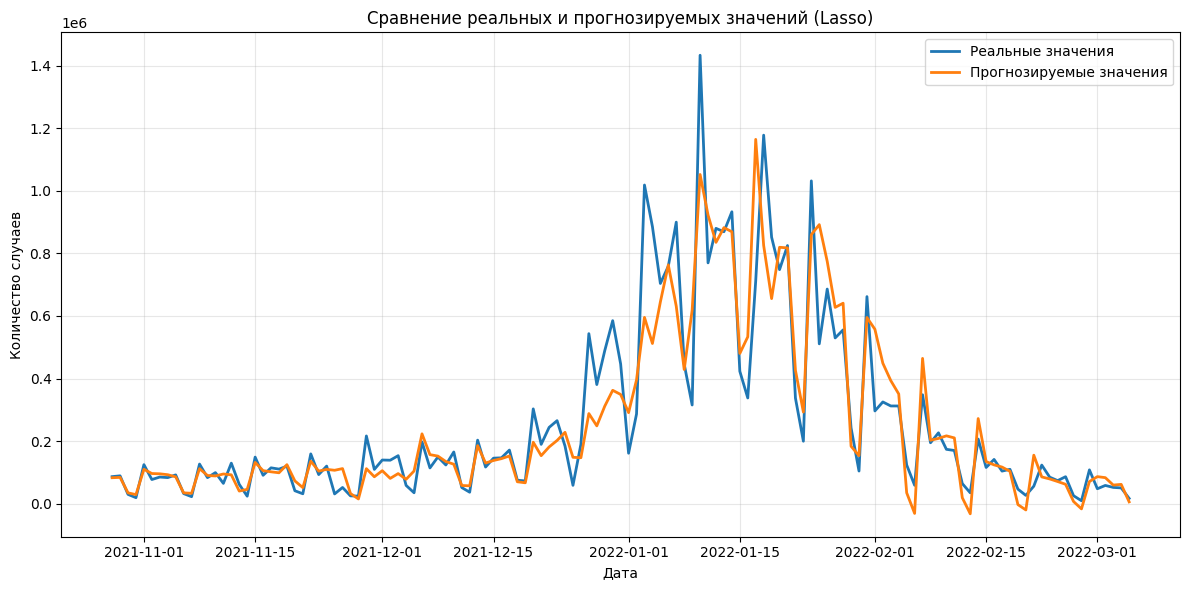

In [28]:
# 9. Визуализация реальных и прогнозируемых значений
plt.figure(figsize=(12, 6))
plt.plot(target_test.index, target_test, label='Реальные значения', linewidth=2, color='#1f77b4')
plt.plot(target_test.index, pred_test, label='Прогнозируемые значения', linewidth=2, color='#ff7f0e')
plt.title(f'Сравнение реальных и прогнозируемых значений ({best_model_name})')
plt.xlabel('Дата')
plt.ylabel('Количество случаев')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

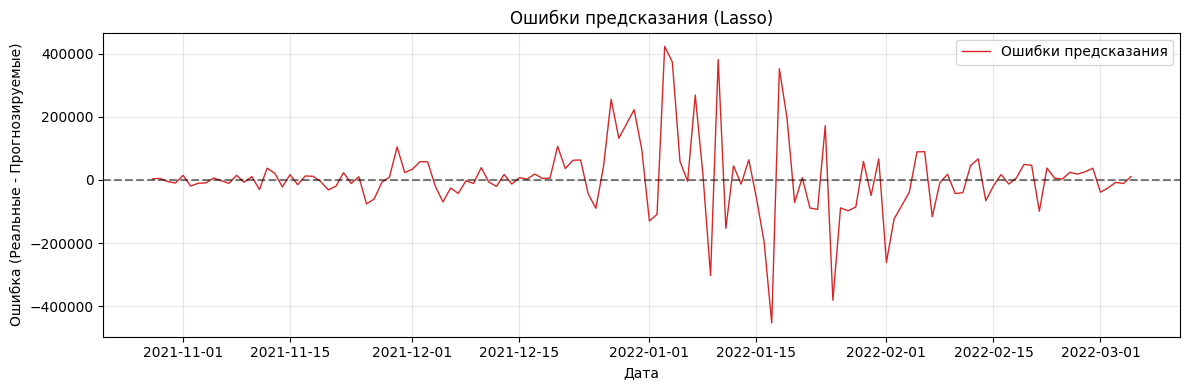


Статистика ошибок предсказания:
Средняя ошибка: 6114.30
Стандартное отклонение ошибок: 116545.83
Максимальная ошибка: 423350.44
Минимальная ошибка: -452860.11


In [29]:
# график ошибок предсказания
errors = target_test - pred_test
plt.figure(figsize=(12, 4))
plt.plot(target_test.index, errors, label='Ошибки предсказания', color='#d62728', linewidth=1)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.title(f'Ошибки предсказания ({best_model_name})')
plt.xlabel('Дата')
plt.ylabel('Ошибка (Реальные - Прогнозируемые)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Статистика ошибок
print(f"\nСтатистика ошибок предсказания:")
print(f"Средняя ошибка: {errors.mean():.2f}")
print(f"Стандартное отклонение ошибок: {errors.std():.2f}")
print(f"Максимальная ошибка: {errors.max():.2f}")
print(f"Минимальная ошибка: {errors.min():.2f}")

In [30]:
# 10. Выводы
print("\nВыводы:")
print(f"1. Лучшая модель: {best_model_name} с параметрами {best_params}")
print(f"2. Качество прогноза: RMSE = {rmse_test:.2f}, R² = {r2_test:.4f}")
print("3. Lasso показал значительно лучшие результаты по сравнению с другими моделями")
print("4. Данные имеют выраженную линейную зависимость, что объясняет успех Lasso")
print("5. Модель может использоваться для краткосрочного прогнозирования случаев COVID-19")
print("6. Для улучшения точности можно добавить дополнительные признаки и внешние данные")


Выводы:
1. Лучшая модель: Lasso с параметрами {'alpha': 10}
2. Качество прогноза: RMSE = 116254.12, R² = 0.8373
3. Lasso показал значительно лучшие результаты по сравнению с другими моделями
4. Данные имеют выраженную линейную зависимость, что объясняет успех Lasso
5. Модель может использоваться для краткосрочного прогнозирования случаев COVID-19
6. Для улучшения точности можно добавить дополнительные признаки и внешние данные
